In [84]:
import torch
import pyro
from pyro.distributions import *
from collections import Counter
import pyro.infer
import pyro.optim
pyro.enable_validation(True)
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import numpy as np
import pandas as pd

pyro.enable_validation(True)

# A Cognitive Model or Harmonic Types

## Model

A chord consists of a number of notes,
which are either generated as stable chord tones or as ornaments.
We model this process by distinguishing (for each chord type)
a distribution of chord tones and a distribution of ornaments.
For each generated note, a coin is flipped as to whether the tone is generated as a chord tone or ornament.
The pitch is then drawn from the corresponding distribution.
Since we don't always know the type of a note, we flip another coin to decide whether the type is observed or not (in which case `unknown` is emitted for both ornaments and chordtones).

Priors:
- choose $\vec\chi \sim \text{Dirichlet}(0.5, n_\text{harmonies})$
- choose $\theta \sim \text{Beta}(1,1)$
- choose $\lambda \sim \text{Gamma}(3,1)$
- for each chord type $i$
  - choose $\vec\phi_{ct}^{(i)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$
  - choose $\vec\phi_{or}^{(i)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$

Generating a single chord (long version):
- choose $h \sim \text{Categorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- for each note $i \in 1, \ldots, n$:
  - choose $t_i \sim \text{Bernoulli}(\theta)$
  - choose $p_i \sim \begin{cases}
                       \text{Categorical}(\vec\phi_{ct}^{(h)}) & \text{if } t_i = 1\\
                       \text{Categorical}(\vec\phi_{or}^{(h)}) & \text{if } t_i = 0
                     \end{cases}$
  - choose $o_i \sim \text{Bernoulli}(p_\text{obs})$
  - choose $ot_i = \begin{cases}
                     \text{'chordtone'} & \text{if } o_i = 1 \wedge p_i = 1\\
                     \text{'ornament'} & \text{if } o_i = 1 \wedge p_i = 0\\
                     \text{'unknown'} & \text{if } o_i = 0\\
                   \end{cases}$
- count $(p_i,ot_i)$ pairs

Generating a single chord (compact version)
- choose $h \sim \text{Catecorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- choose $n_{p,ot} \sim \text{Multinomial}(n, \vec\nu),$ where
  - $\nu_{ct} = p_\text{obs} \cdot \theta \cdot \vec\phi_{ct}^{(h)}$
  - $\nu_{or} = p_\text{obs} \cdot (1-\theta) \cdot \vec\phi_{or}^{(o)}$
  - $\nu_{uk} = (1-p_\text{obs}) \cdot \left( \theta \vec\phi_{ct}^{(h)} + (1-\theta) \vec\phi_{or}^{(h)} \right)$
  - $\nu = \text{concat}(\nu_{ct}, \nu_{or}, \nu_{uk})$

In [115]:
#nharmonies = 10
npcs = 4*7+1 # around C: Cbb to C## on LoF

#@pyro.infer.config_enumerate
def chord_model(npcs, nharmonies, nchords, pobserve=0.5):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(0.5 * torch.ones(nharmonies)))
    # distribution of ornament probability
    p_is_chordtone = pyro.sample('p_is_chordtone', Beta(1, 1))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies) as ind:
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(0.5 * torch.ones(npcs)))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(0.5 * torch.ones(npcs)))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        p_ct = p_is_chordtone       * p_chordtones
        p_or = (1 - p_is_chordtone) * p_ornaments
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    # distribution of note rate in chords
    rate_notes = pyro.sample('rate_notes', Gamma(3,1))
    
    # sampling the data:
    chords = list()
    for c in pyro.plate('data', nchords, subsample_size=500):
        # pick a harmony
        h = pyro.sample('h_{}'.format(c), Categorical(p_harmony))
        # pick a number of notes
        nnotes = 1 + pyro.sample('n_{}'.format(c), Poisson(rate_notes)).int().item()
        # sample chordtones
        chordtones = pyro.sample('chord_{}'.format(c), Multinomial(nnotes, p_tones[h]))
        chords.append({'h': h, 'n': nnotes,
                       'counts': chordtones.reshape((npcs, 3))})
    return chords

In [111]:
chord_model(npcs, 3, 4)

torch.Size([3, 29])


[{'h': tensor(2),
  'n': 4,
  'counts': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 0.],
          [0., 0., 0.]])}]

## Guide

A simple guide that assumes the latent variables to be distributed independently.

In [118]:
def chord_guide(npcs, nharmonies, nchords, pobserve=0.5):
    # posterior of p_harmony
    params_p_harmony = pyro.param('params_p_harmony', 0.5 * torch.ones(nharmonies),
                                  constraint=constraints.positive)
    pyro.sample('p_harmony', Dirichlet(params_p_harmony))
    
    # posteriors of notes dists in harmonies
    params_p_chordtones = pyro.param('params_p_chordtones', 0.5 * torch.ones(nharmonies, npcs),
                                     constraint=constraints.positive)
    params_p_ornaments = pyro.param('params_p_ornaments', 0.5 * torch.ones(nharmonies, npcs),
                                    constraint=constraints.positive)
    with pyro.plate('harmonies', nharmonies) as ind:
        pyro.sample('p_chordtones', Dirichlet(params_p_chordtones))
        pyro.sample('p_ornaments', Dirichlet(params_p_ornaments))
        
    # posterior of note rate
    alpha_rate_notes = pyro.param('alpha_rate_notes', torch.tensor(3.),
                                  constraint=constraints.positive)
    beta_rate_notes = pyro.param('beta_rate_notes', torch.tensor(1.),
                                 constraint=constraints.positive)
    rate_notes = pyro.sample('rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))
    
    # posterior of ornament probability
    alpha_p_ict = pyro.param('alpha_p_ict', torch.tensor(1.), constraint=constraints.positive)
    beta_p_ict = pyro.param('beta_p_ict', torch.tensor(1.), constraint=constraints.positive)
    pyro.sample('p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))

## Data and Conditioning

In [88]:
def chord_tensor(notes):
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = torch.zeros((npcs, 3))
    for (pitch, t) in notes:
        chord[pitch%npcs, notetype[t]] += 1
    return chord

def annot_data_obs(chords):
    obs = {}
    for (i, chord) in enumerate(chords):
        obs["h_{}".format(i)] = torch.tensor(chord["label"])
        obs["n_{}".format(i)] = torch.tensor(len(chord["notes"]) - 1.)
        obs["chord_{}".format(i)] = chord_tensor(chord["notes"]).flatten()
    return obs

In [14]:
example_chords = [
    {'label': 0, 'notes': [(0,'chordtone'), (4,'chordtone'), (1,'chordtone'), (4,'ornament')]},
    {'label': 1, 'notes': [(0,'chordtone'), (-3,'chordtone'), (1,'chordtone'), (-2,'unknown')]}
]
example_obs = annot_data_obs(example_chords)
example_obs

{'h_0': tensor(0),
 'n_0': tensor(3.),
 'chord_0': tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'h_1': tensor(1),
 'n_1': tensor(3.),
 'chord_1': tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])}

In [15]:
# load wikifonia data
wiki_harms = pd.read_csv('data/harmonies.csv', sep='\t')
wiki_harms

,chordid,label,fifth,type
0,0,major,4,chordtone
1,0,major,1,chordtone
2,0,major,0,chordtone
3,0,major,1,chordtone
4,1,dominant,-2,ornament
...,...,...,...,...
898831,279775,major,0,chordtone
898832,279776,major,4,unknown
898833,279776,major,2,unknown
898834,279778,major,1,chordtone


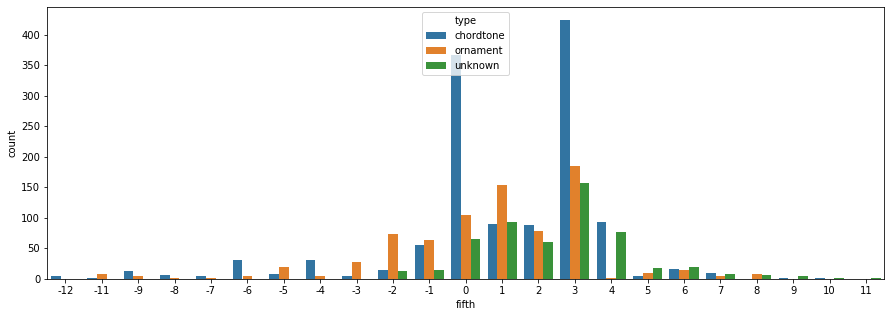

In [193]:
chord_df = wiki_harms[wiki_harms['label']=='dominant-13th']
plt.figure(figsize=(15,5))
sns.countplot(x='fifth', hue='type', data=chord_df)

In [212]:
s = wiki_harms.groupby(['chordid', 'label']).size()
s.nlargest(20)

chordid  label             
53233    diminished-seventh    689
88367    dominant              673
76017    major                 264
1515     major                 247
199012   major                 243
204074   minor                 220
206046   dominant              174
167631   minor                 133
81813    major-seventh         124
181004   minor                 121
17316    minor                 120
211805   major                 117
88348    dominant              110
128598   minor                 108
88376    dominant              104
254248   major                  97
64586    major                  96
48245    minor                  90
132217   dominant               89
204044   minor                  89
dtype: int64

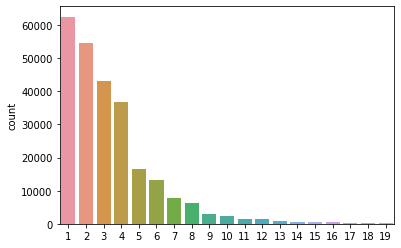

In [216]:
sns.countplot(s[s < 20])

In [17]:
# chord type lexicon
wiki_harmtypes = list(set(wiki_harms.label))

wiki_harms['numlabel'] = wiki_harms['label'].map(wiki_harmtypes.index)
wiki_chords = [{'label': label, 'notes': list(zip(grp.fifth, grp.type))}
              for (_, label), grp in wiki_harms.groupby(['chordid', 'numlabel'])]

In [19]:
wiki_chords[1]

{'label': 41,
 'notes': [(-2, 'ornament'),
  (0, 'ornament'),
  (-2, 'ornament'),
  (3, 'ornament'),
  (1, 'unknown'),
  (1, 'unknown'),
  (1, 'unknown'),
  (1, 'unknown'),
  (4, 'chordtone')]}

In [20]:
wiki_obs = annot_data_obs(wiki_chords)

In [116]:
# condition on the data
conditioned_model = pyro.condition(chord_model, data=wiki_obs)
nharms = len(wiki_harmtypes)
nchords = len(wiki_chords)
print(nharms, "chord types")
print(nchords, "chords")

49 chord types
258513 chords


## Inference

100%|██████████| 5000/5000 [1:13:18<00:00,  1.14it/s]


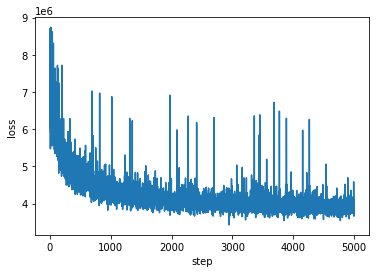

In [148]:
# optimize the parameters of the guide
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_model,
                     guide=chord_guide,
                     optim=pyro.optim.Adam({"lr": 0.005, "betas": (0.95, 0.999)}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
#chord_guide(npcs, 3, 2) # collect params
param_values = {name:[] for name in ['alpha_rate_notes', 'beta_rate_notes', 'alpha_p_ict', 'beta_p_ict']}

nsteps = 5000
for i in tqdm.trange(nsteps):
    losses.append(svi.step(npcs, nharms, nchords))
    for (name, value) in pyro.get_param_store().items():
        if name in param_values:
            param_values[name].append(value.item())

plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

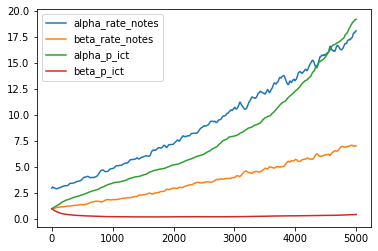

In [149]:
df = pd.DataFrame(param_values)
df.plot()

In [150]:
# show optimized parameters:
for (name, value) in pyro.get_param_store().items():
    print(name, ":\t", value)

params_p_harmony :	 tensor([1.0149e+01, 1.5574e+02, 4.8696e+00, 3.8555e-02, 9.4482e-02, 2.2924e-01,
        5.6702e-01, 5.5550e-01, 1.4286e+01, 5.8340e-01, 1.2230e+00, 4.7505e+00,
        4.9042e+00, 3.9926e-02, 9.4387e+00, 9.7386e+00, 4.6429e-01, 2.5020e+00,
        1.8822e+00, 3.0991e-02, 8.4248e-02, 3.9255e-02, 4.5198e+01, 2.6605e-02,
        5.0138e-01, 3.8950e-02, 2.6845e-02, 3.0889e+00, 1.7570e+00, 2.7355e-02,
        9.0032e-02, 1.5415e-01, 2.7040e-02, 6.0969e-01, 2.0180e+00, 2.9920e+00,
        2.0947e+00, 1.7409e+00, 3.6936e+00, 5.2352e+01, 6.4379e+00, 1.0302e+02,
        4.3479e-02, 4.3073e-02, 2.2317e-01, 1.1730e-01, 3.6027e-02, 1.2215e-01,
        3.7559e+00], grad_fn=<AddBackward0>)
params_p_chordtones :	 tensor([[18.7539, 12.9979,  7.7340,  ...,  0.5067,  4.8683,  0.4361],
        [46.1218, 26.6287, 16.0534,  ...,  0.8458,  9.8835,  2.1557],
        [ 9.5346, 12.6233,  7.9227,  ...,  1.7205,  6.8595,  0.5050],
        ...,
        [ 0.9763,  1.1009,  0.4685,  ...,  0.2433

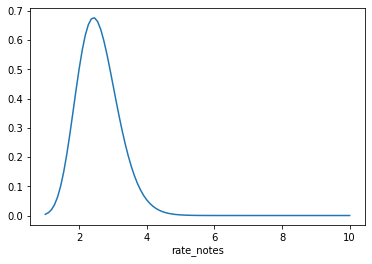

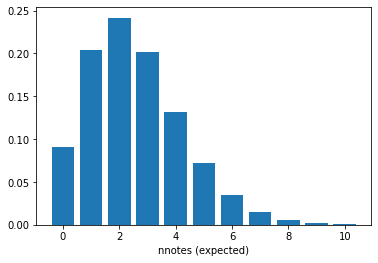

In [217]:
# posterior of 'rate_notes'
a = pyro.get_param_store().get_param("alpha_rate_notes").item()
b = pyro.get_param_store().get_param("beta_rate_notes").item()
x = np.linspace(1,10,100)
y = np.exp(Gamma(a,b).log_prob(x))
plt.plot(x,y)
plt.xlabel('rate_notes')
plt.show()
xrate = torch.linspace(0,10,11)
yrate = np.exp(GammaPoisson(a,b).log_prob(xrate))
plt.bar(xrate, yrate)
plt.xlabel('nnotes (expected)')
plt.show()

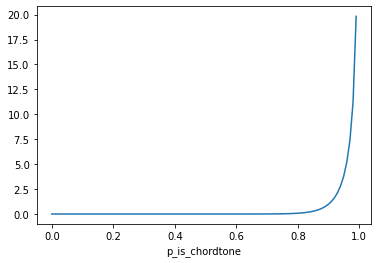

In [218]:
# posterior of 'p_is_chordtone'
post_p_ict_alpha = pyro.get_param_store().get_param("alpha_p_ict").item()
post_p_ict_beta  = pyro.get_param_store().get_param("beta_p_ict").item()
x = torch.linspace(0,1,100)
y = np.exp(Beta(post_p_ict_alpha, post_p_ict_beta).log_prob(x))
plt.plot(x,y)
plt.xlabel("p_is_chordtone")
plt.show()

In [257]:
def plot_chord_type_dist(params, labels):
    plt.figure(figsize=(6,9))
    plt.barh(np.arange(len(params)), params, tick_label=labels)
    plt.show()

[1.0149244e+01 1.5573915e+02 4.8696465e+00 3.8555335e-02 9.4482027e-02
 2.2924189e-01 5.6702262e-01 5.5550480e-01 1.4286464e+01 5.8339572e-01
 1.2229661e+00 4.7504854e+00 4.9041686e+00 3.9925680e-02 9.4387150e+00
 9.7386484e+00 4.6429241e-01 2.5020244e+00 1.8821651e+00 3.0990543e-02
 8.4248260e-02 3.9255217e-02 4.5198376e+01 2.6604874e-02 5.0137675e-01
 3.8950130e-02 2.6845094e-02 3.0889060e+00 1.7569711e+00 2.7354686e-02
 9.0031676e-02 1.5414661e-01 2.7040359e-02 6.0968727e-01 2.0179980e+00
 2.9920185e+00 2.0947073e+00 1.7408799e+00 3.6936102e+00 5.2351978e+01
 6.4379468e+00 1.0301988e+02 4.3479495e-02 4.3072913e-02 2.2317374e-01
 1.1730155e-01 3.6026932e-02 1.2214721e-01 3.7558529e+00]
[nan, 'major', '7', 'maj69', 'min9', '9', 'minor-11th', 'dominant-11th', 'major-seventh', 'power', 'major-ninth', 'minor-sixth', 'min', 'pedal', 'dominant-ninth', 'major-sixth', 'minor-major', 'augmented', 'maj7', 'minor-13th', 'aug', 'maj9', 'minor-seventh', 'min/G', 'dim', 'dim7', 'minMaj7', 'diminis

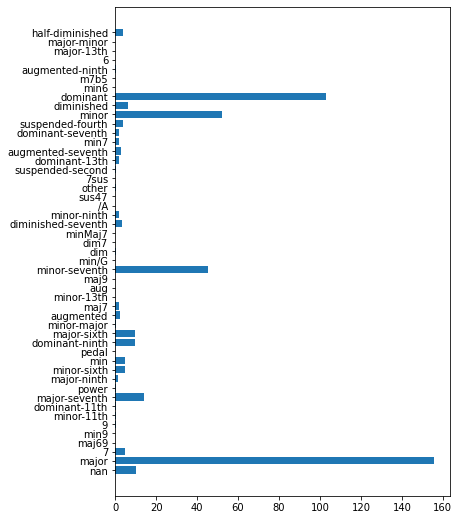

In [259]:
#post_p_harmony = pyro.get_param_store().get_param("params_p_harmony").detach().numpy()
print(post_p_harmony)
print(wiki_harmtypes)

plot_chord_type_dist(post_p_harmony, wiki_harmtypes)

In [181]:
def plot_chord(chordtones, ornaments, name):
    off = npcs // 2
    cs = np.roll(chordtones, off)
    os = np.roll(ornaments, off)
    labels = np.arange(-off, off+1)
    x = np.arange(npcs)
    width = 0.4
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar(x - width/2, cs, width, label='chord tones')
    plt.bar(x + width/2, os, width, label='ornaments')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
#     fig, ax = plt.subplots(2, 1, figsize=(12,9))
#     ax[0].bar(np.arange(npcs), cs, tick_label=labels)
#     ax[0].set_title("{} chord tones".format(name))
#     ax[1].bar(np.arange(npcs), os, tick_label=labels)
#     ax[1].set_title("{} ornaments".format(name))
    plt.show()

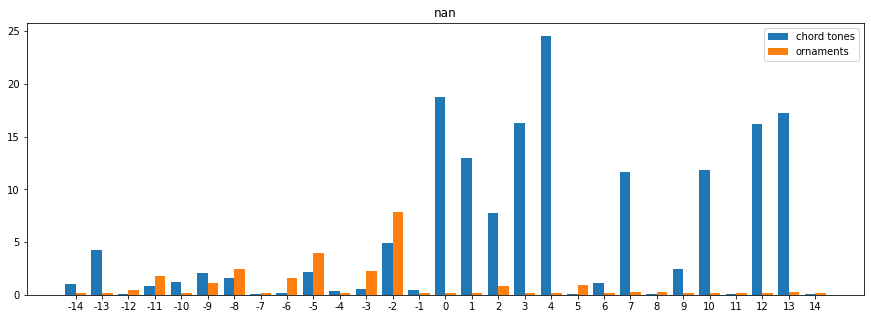

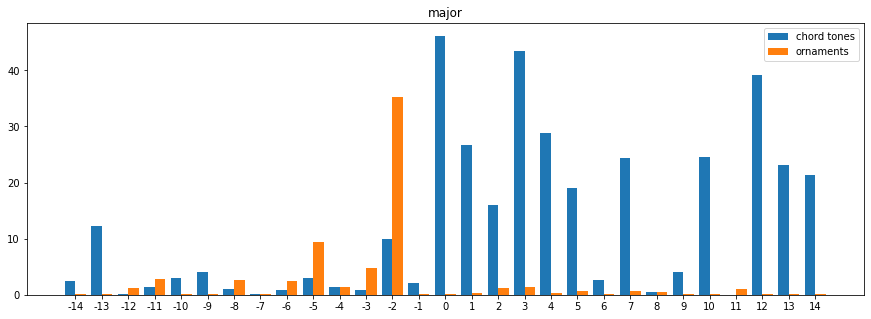

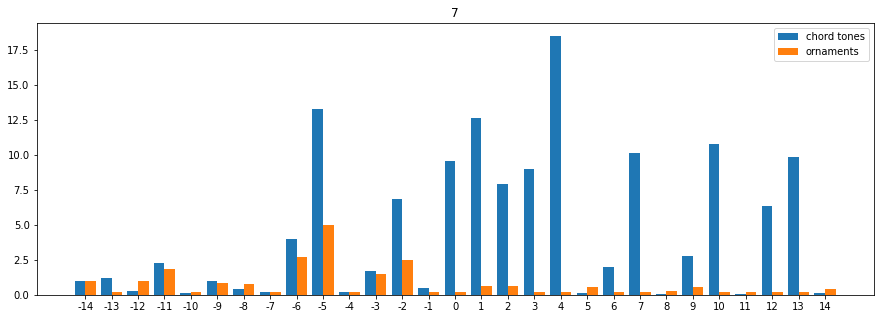

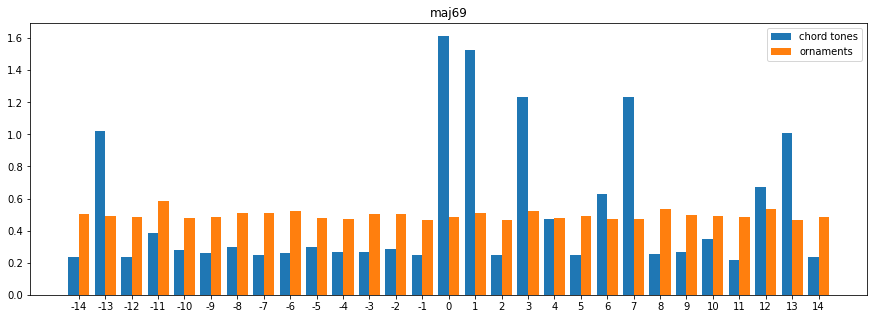

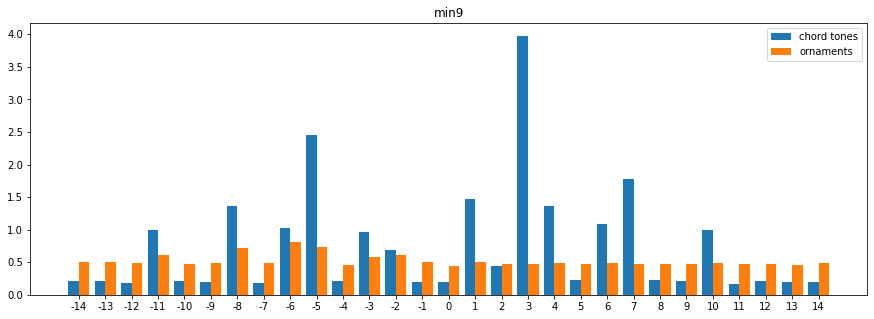

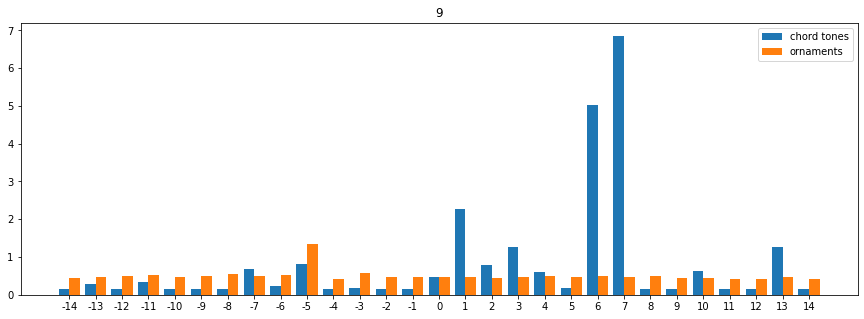

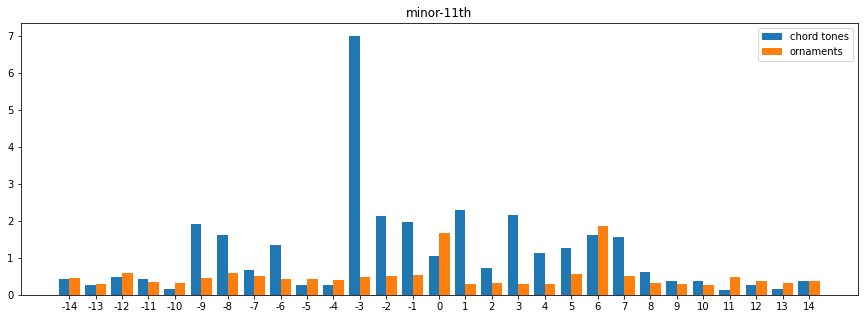

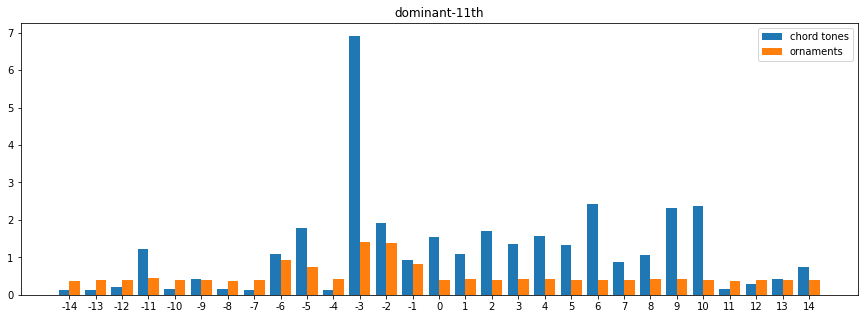

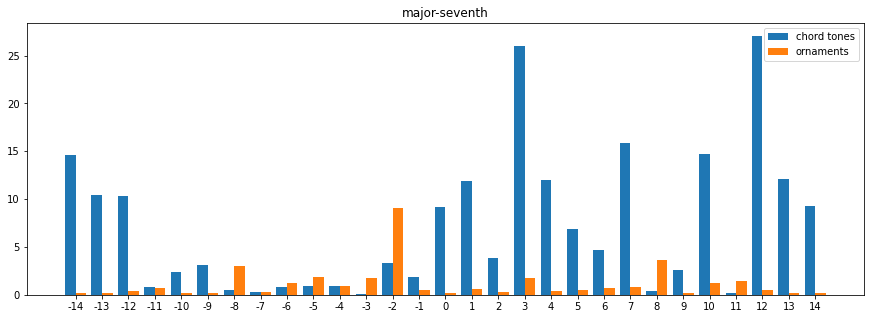

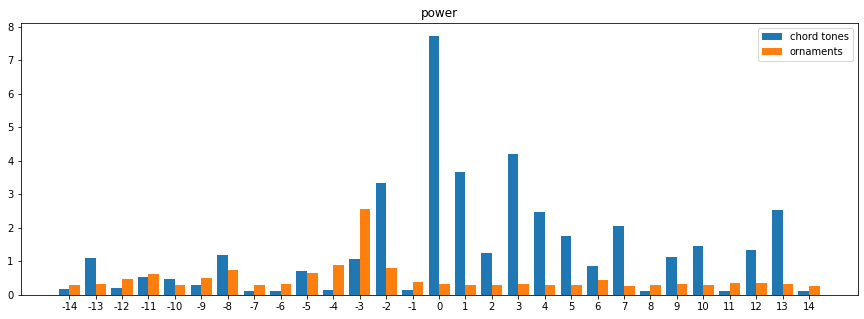

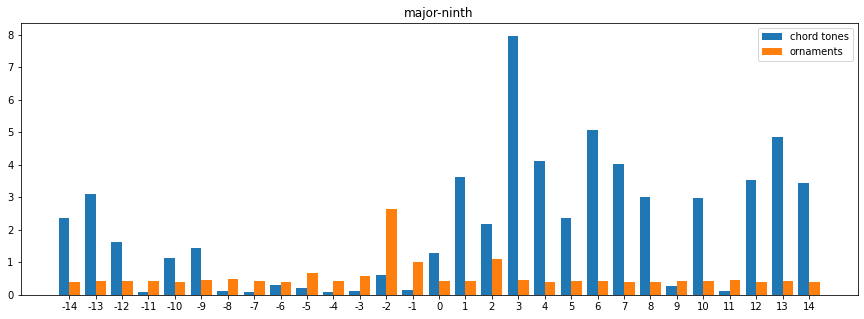

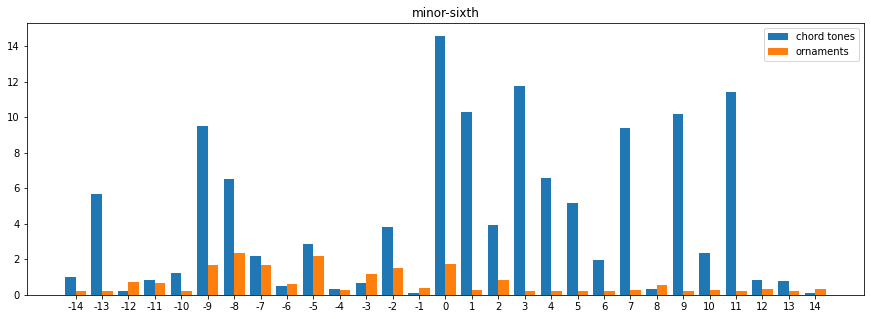

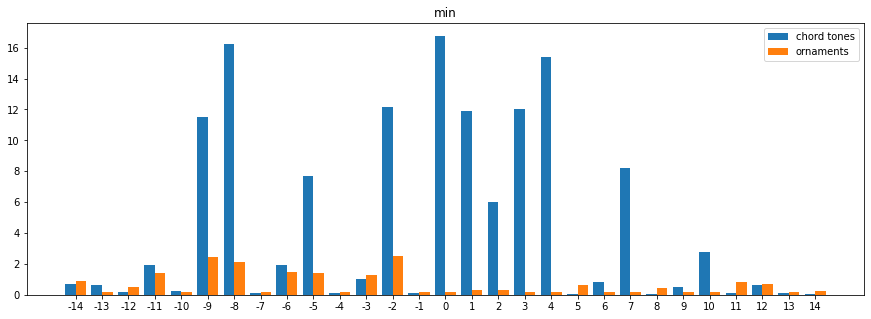

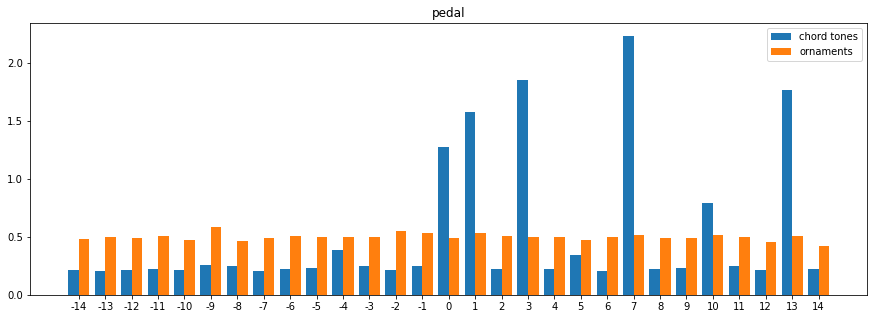

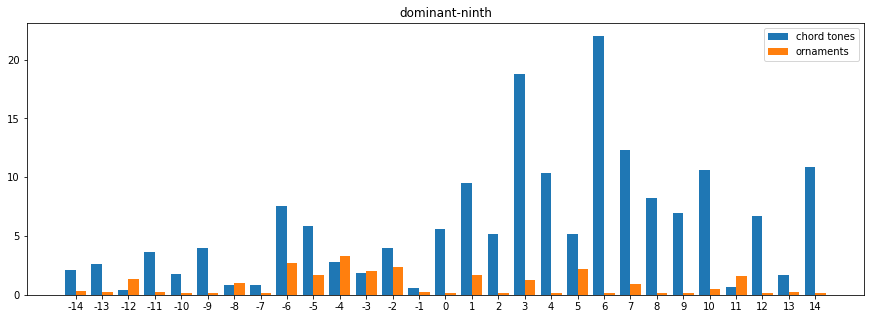

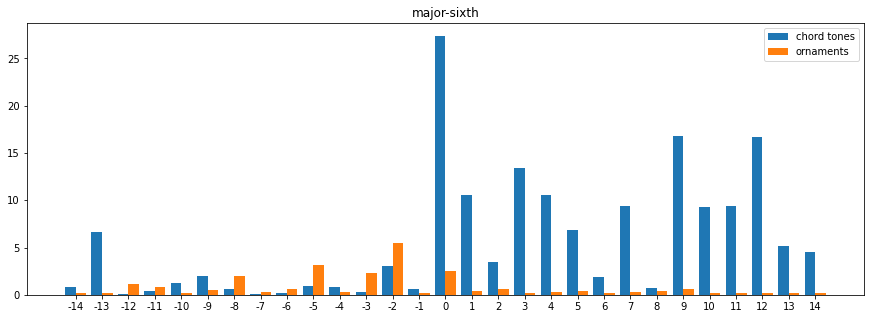

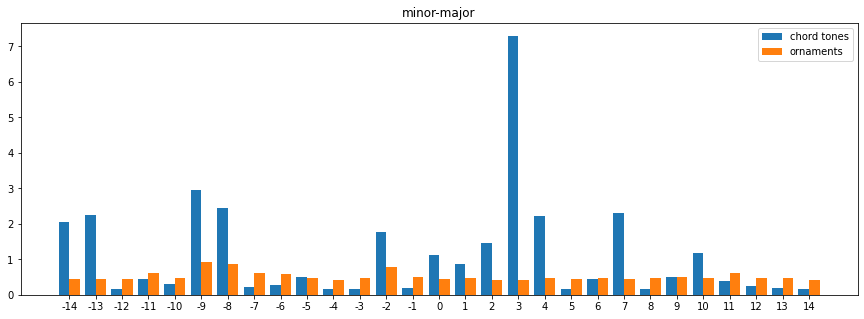

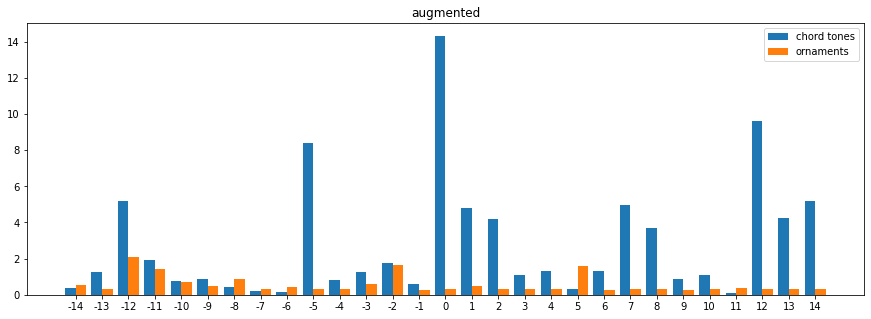

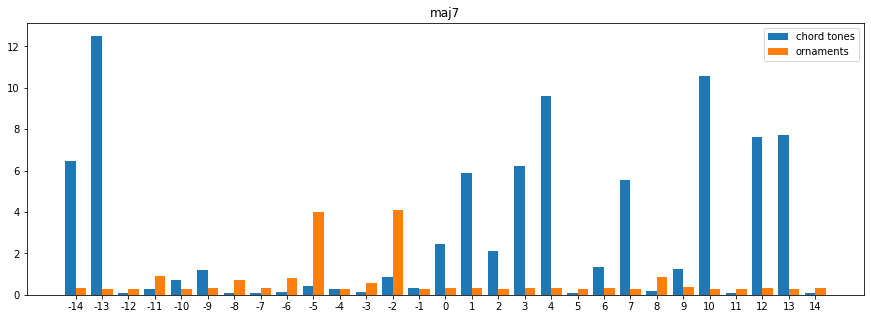

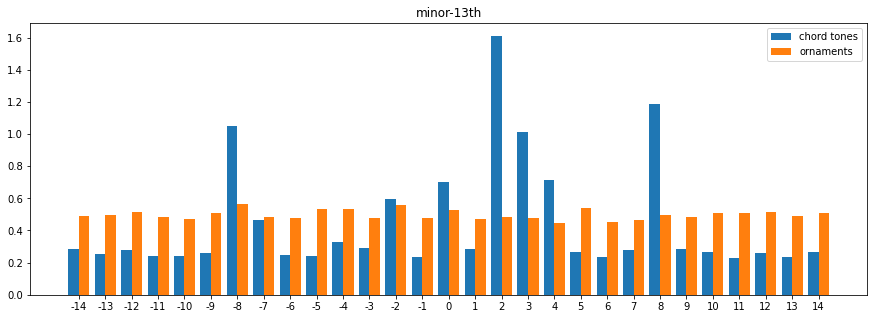

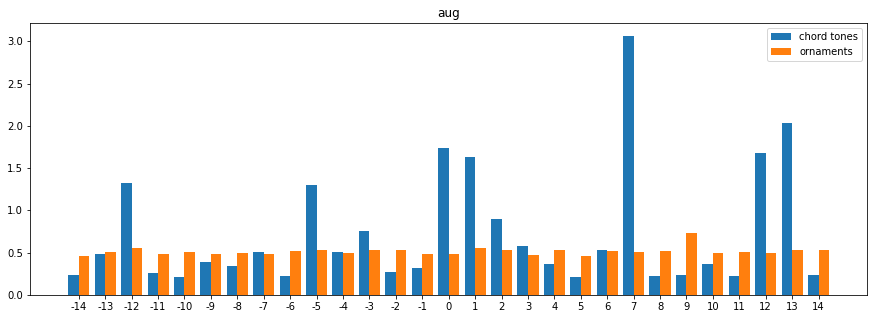

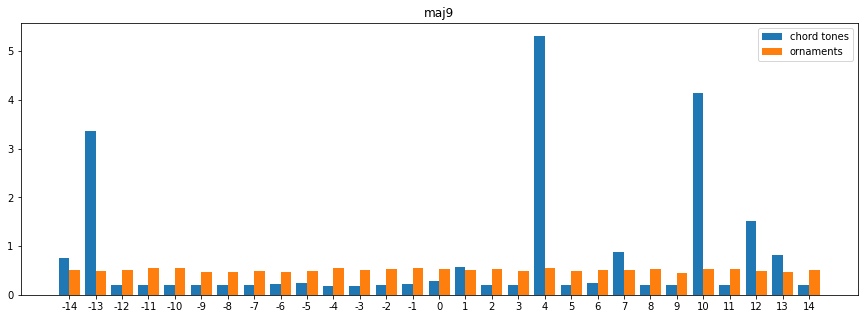

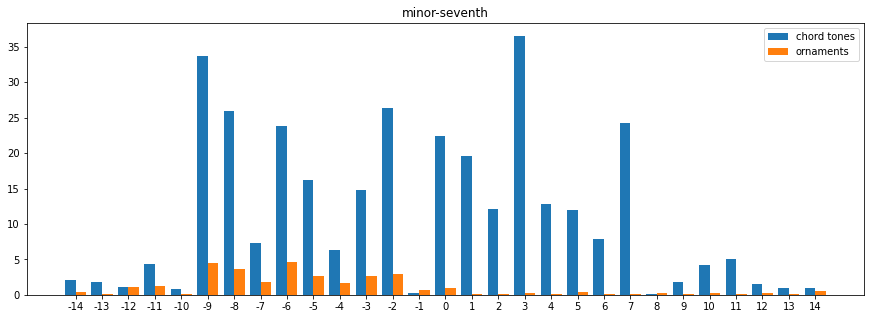

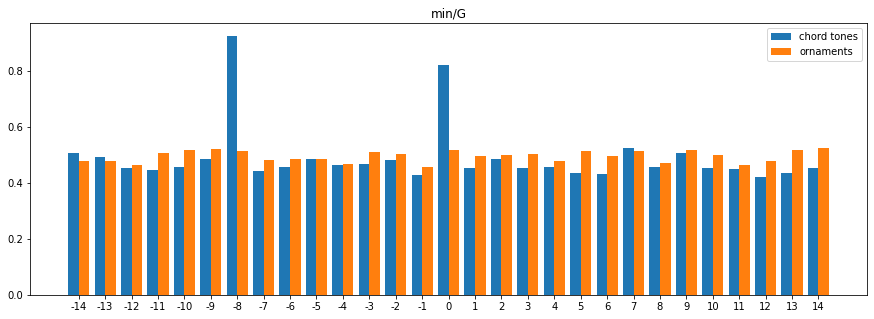

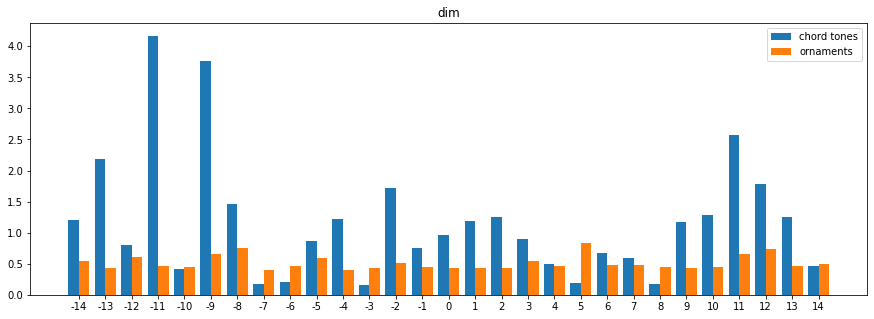

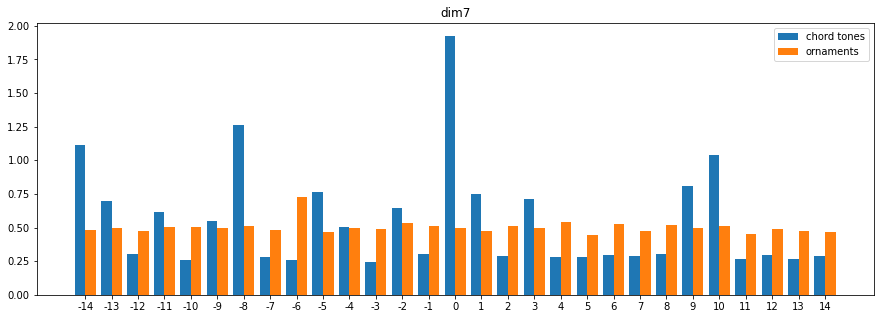

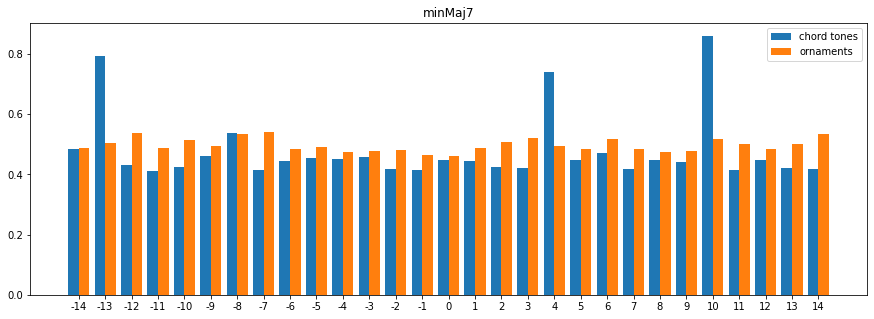

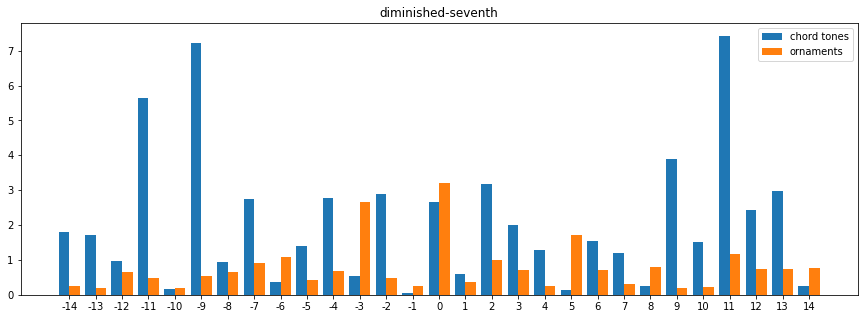

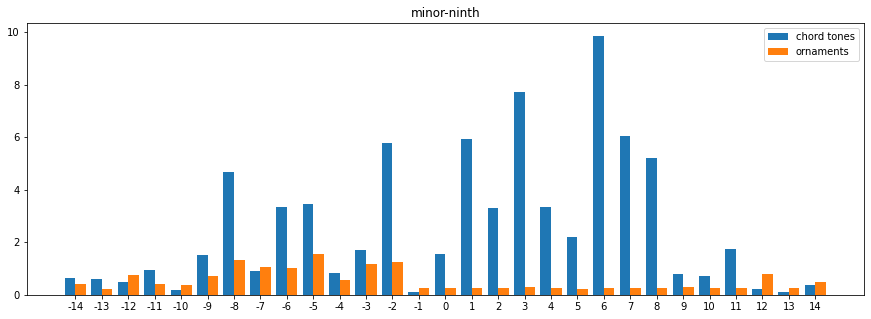

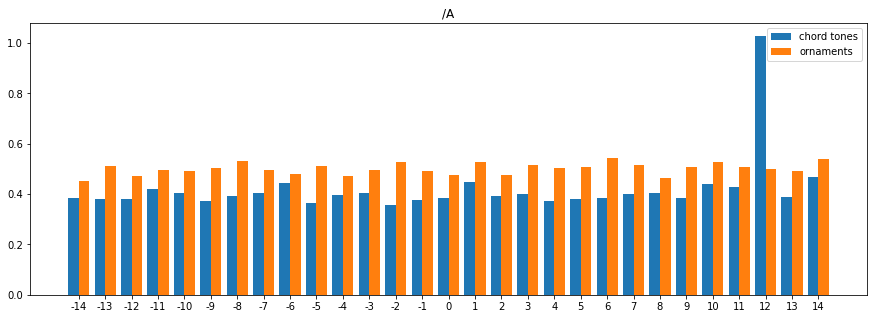

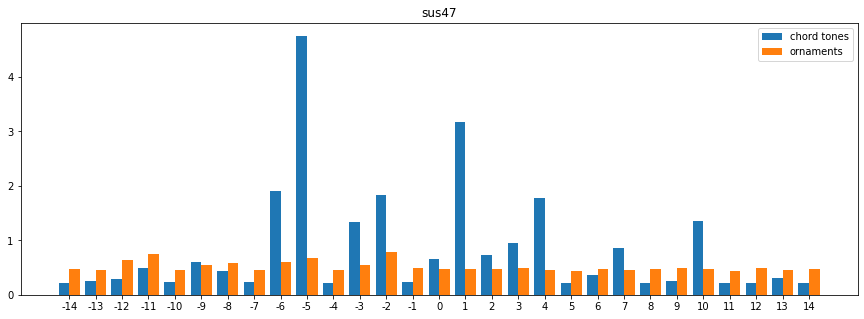

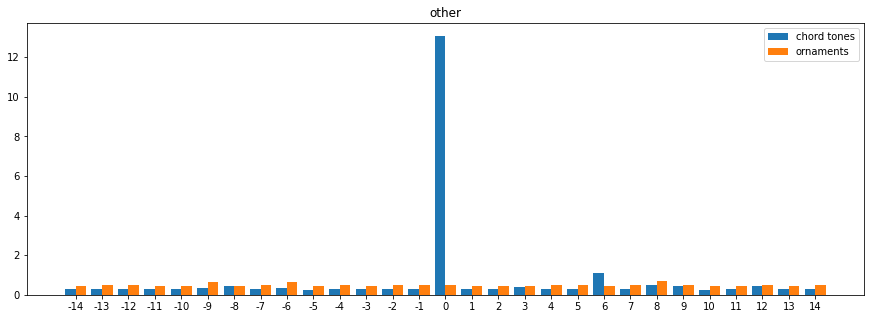

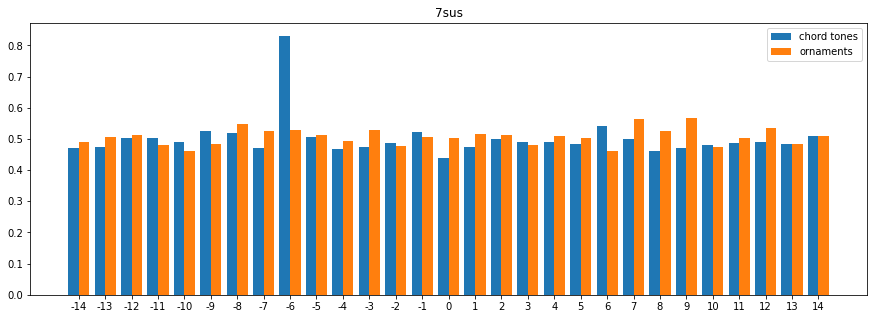

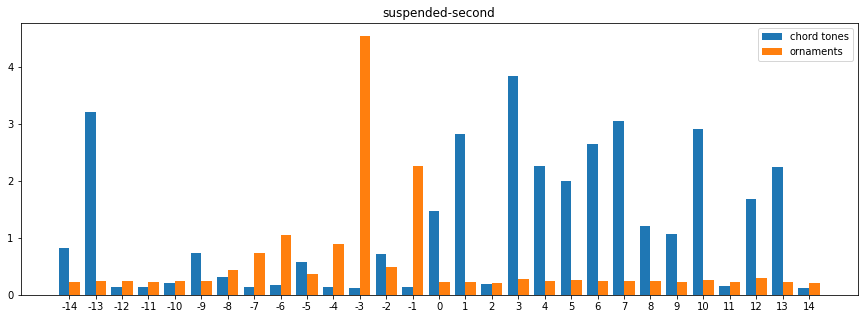

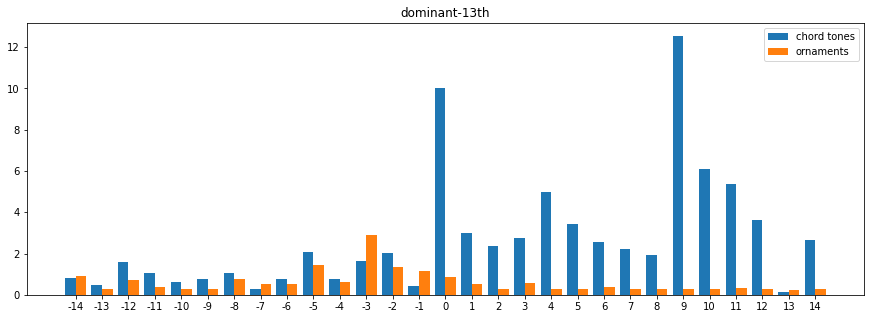

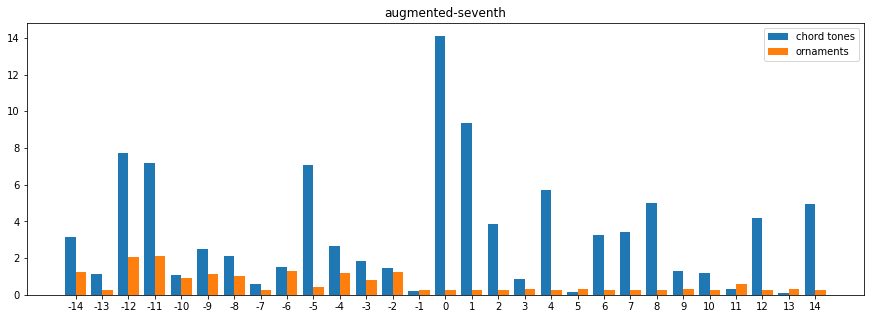

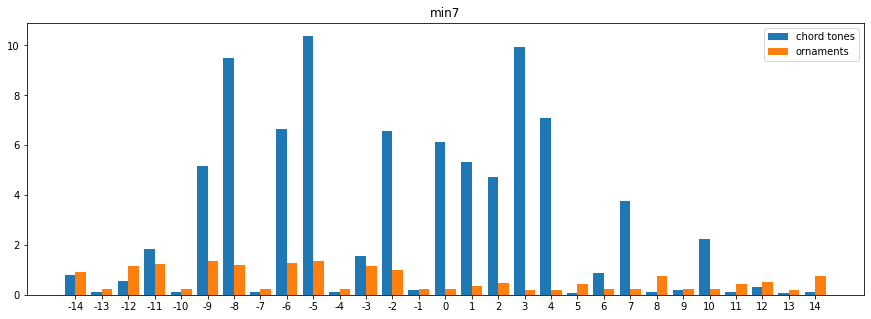

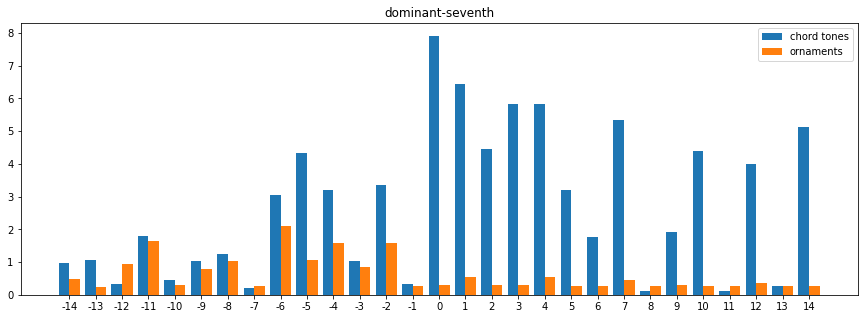

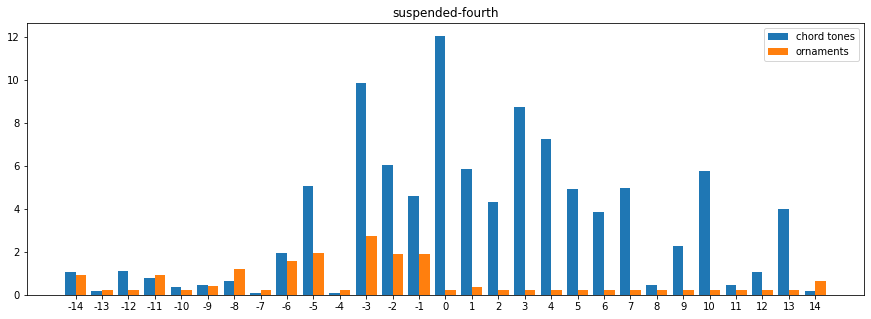

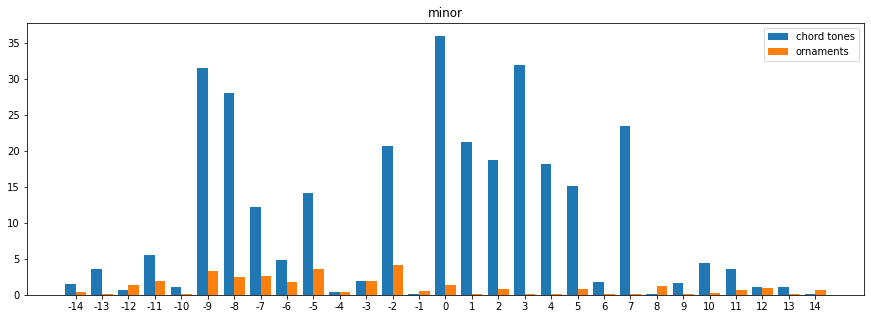

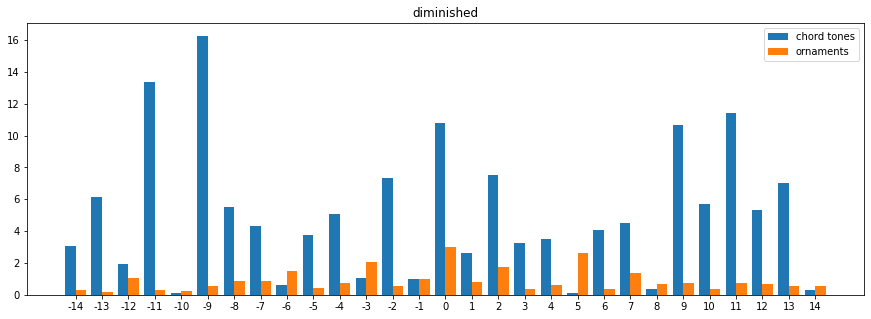

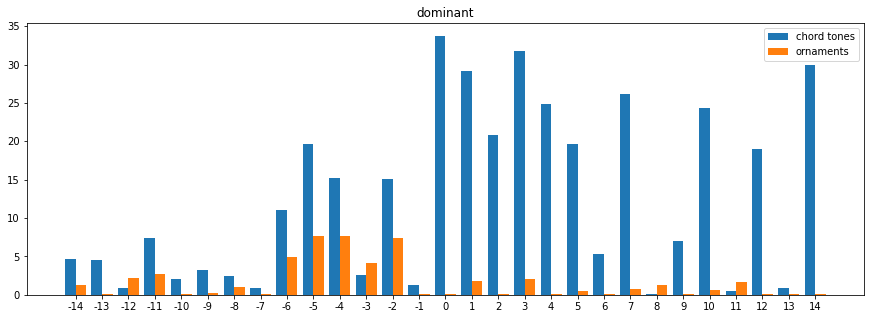

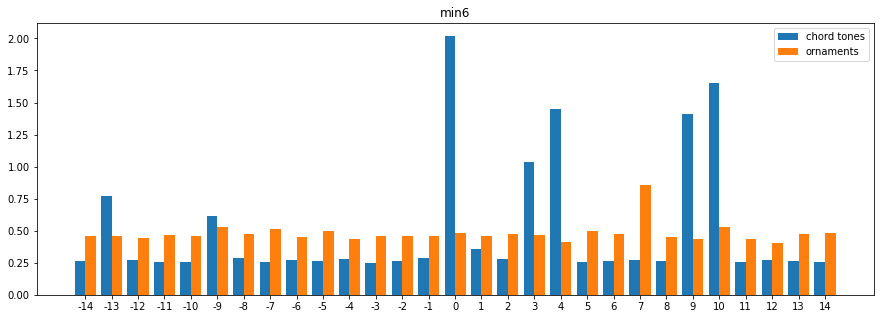

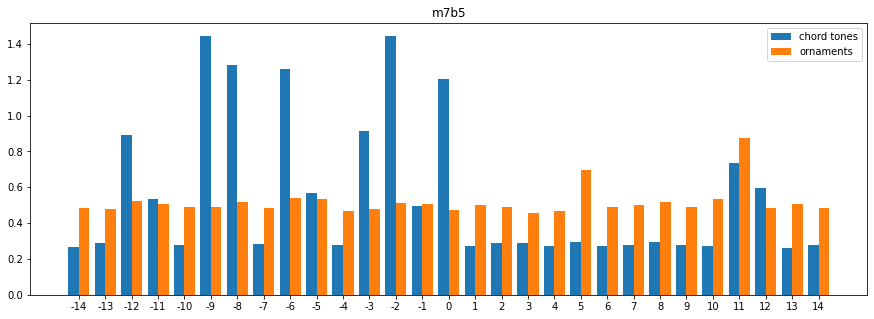

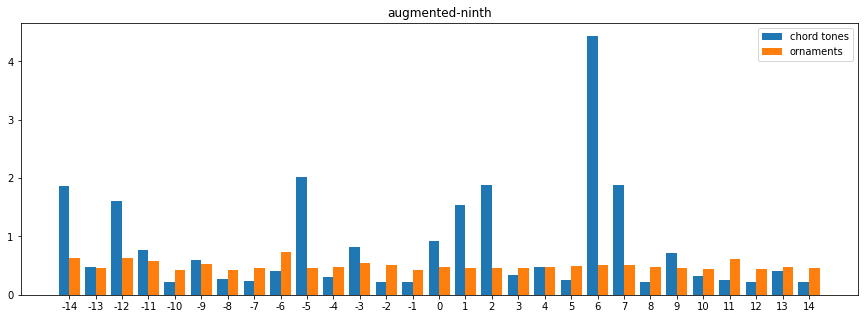

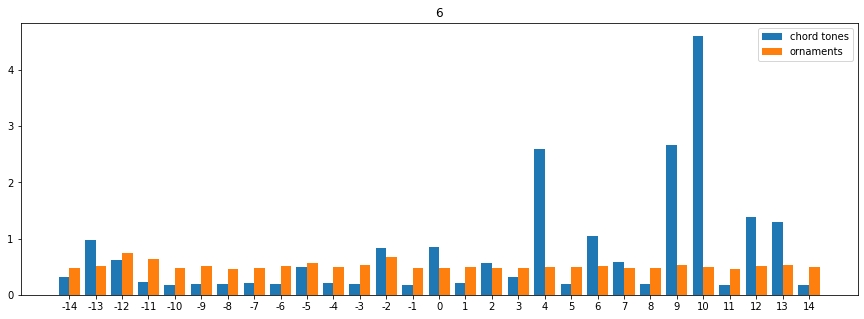

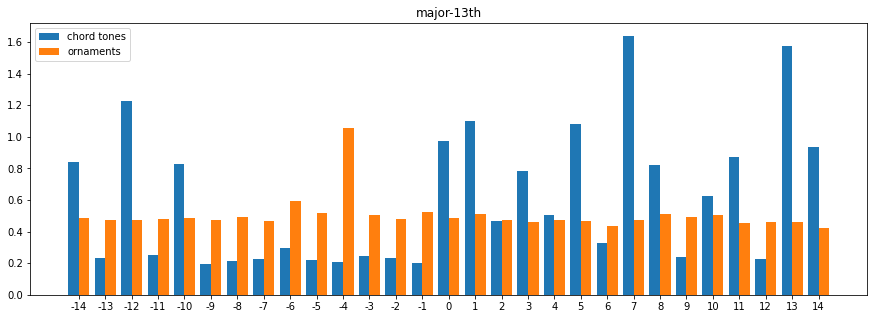

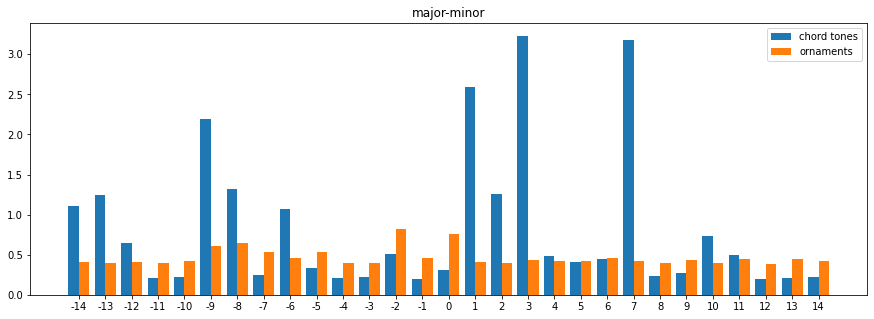

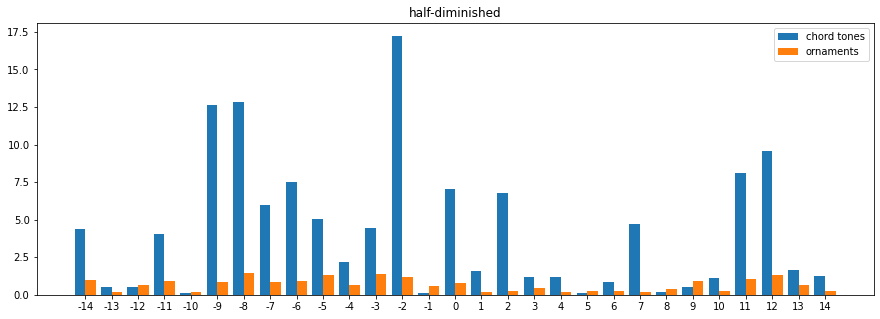

In [183]:
post_chordtones = pyro.get_param_store().get_param("params_p_chordtones").detach().numpy()
post_ornaments = pyro.get_param_store().get_param("params_p_ornaments").detach().numpy()
for i, name in enumerate(wiki_harmtypes):
    plot_chord(post_chordtones[i], post_ornaments[i], name)

In [155]:
post_chordtones

array([[18.753881  , 12.997941  ,  7.7339997 , ...,  0.50669074,
         4.8683443 ,  0.43613034],
       [46.121822  , 26.628706  , 16.053392  , ...,  0.8457548 ,
         9.883506  ,  2.155737  ],
       [ 9.534574  , 12.623261  ,  7.92269   , ...,  1.7205151 ,
         6.859498  ,  0.5049644 ],
       ...,
       [ 0.9762837 ,  1.1009278 ,  0.46851087, ...,  0.2433143 ,
         0.23455903,  0.20219742],
       [ 0.3142812 ,  2.5869102 ,  1.2571263 , ...,  0.22049792,
         0.5046836 ,  0.19635276],
       [ 7.069787  ,  1.6115257 ,  6.742804  , ...,  4.433325  ,
        17.227732  ,  0.10981699]], dtype=float32)

# Prediction

once the posterior distribution of the chord types are known, we can use them to predict the chord type of a (new) set of notes.

$$
p(h \mid n', D) = \dfrac{p(n' \mid h, D) p(h \mid D)}{p(n' \mid D)}
$$

$p(h \mid D)$ is represented in the (approximate) posterior by the Dirichlet distribution $p(\chi \mid D)$.
It can be expressed as
$$p(h \mid D) = \int p(h \mid \chi) p(\chi \mid D) d\chi,$$
where $\chi$ is the parameter vector for the categorical Distribution of $h$.

$p(n' \mid h, D)$ is represented in the posterior as a combination of the dirichlet distributions of chord tones $p(\phi_{ct}^{(h)} \mid D)$ and ornaments $p(\phi_{or}^{(h)} \mid D)$ and the beta distribution of the chord-tone probability $p(\theta \mid D)$.
$$
  p(n' \mid h, D) = \int \int \int p(n' \mid \phi_{ct}^{(h)}, \phi_{or}^{(h)}, \theta)
    p(\phi_{ct}^{(h)} \mid D) p(\phi_{or}^{(h)} \mid D) p(\theta \mid D)\ d \phi_{ct}^{(h)} d \phi_{or}^{(h)} d \theta,
$$
where
$$
  p(n' \mid  \phi_{ct}^{(h)}, \phi_{or}^{(h)}, \theta) = Multinomial(|n'|, \nu),
$$
with $\nu$ as defined above.

Since this integral is a bit tricky to calculate (\*ahem\*) we write another model and guide to numerically compute the distribution $p(h \mid n', D)$

In [271]:
def chord_model_pred(npcs, nharmonies, obs_chord, pobserve=0.5):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(torch.tensor(post_p_harmony)))
    # distribution of ornament probability
    p_is_chordtone = pyro.sample('p_is_chordtone', Beta(post_p_ict_alpha, post_p_ict_beta))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies) as ind:
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(torch.tensor(post_chordtones)))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(torch.tensor(post_ornaments)))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        p_ct = p_is_chordtone       * p_chordtones
        p_or = (1 - p_is_chordtone) * p_ornaments
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    
    # sample the chord
    nnotes = obs_chord.sum().int().item()
    h = pyro.sample('h', Categorical(p_harmony))
    chord = pyro.sample('chord', Multinomial(nnotes, p_tones[h]))
    return h, chord

In [272]:
chord_model_pred(npcs, nharms, wiki_obs['chord_0'])

(tensor(22),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]))

In [273]:
@pyro.infer.config_enumerate
def chord_guide_pred(npcs, nharmonies, obs_chord, pobserve=0.5):
    # sample according to known posterior
    pyro.sample('p_harmony', Dirichlet(torch.tensor(post_p_harmony)))
    pyro.sample('p_is_chordtone', Beta(post_p_ict_alpha, post_p_ict_beta))
    with pyro.plate('harmonies', nharmonies) as ind:
        pyro.sample('p_chordtones', Dirichlet(torch.tensor(post_chordtones)))
        pyro.sample('p_ornaments', Dirichlet(torch.tensor(post_ornaments)))
    
    # estimate the predictive
    p_harmony = pyro.param('params_h', torch.ones(nharmonies) / nharmonies, constraint=constraints.simplex)
    nnotes = obs_chord.sum().int().item()
    h = pyro.sample('h', Categorical(p_harmony))

In [291]:
def predict(npcs, nharmonies, notes, pobserve=0.5, iterations=100, plot_loss=True):
    obs_chord = chord_tensor(notes).flatten()
    pyro.clear_param_store()
    cond_pred_model = pyro.condition(chord_model_pred, {'chord' :obs_chord})
    svi = pyro.infer.SVI(model=cond_pred_model,
                         guide=chord_guide_pred,
                         optim=pyro.optim.Adam({"lr": 0.005, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.TraceEnum_ELBO(max_plate_nesting=1))

    losses = []

    for i in tqdm.trange(iterations):
        losses.append(svi.step(npcs, nharms, obs_chord, pobserve))
        
    if plot_loss:
        plt.plot(losses)
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.show()
    
    return pyro.get_param_store().get_param('params_h').detach()

100%|██████████| 1500/1500 [00:16<00:00, 90.91it/s]


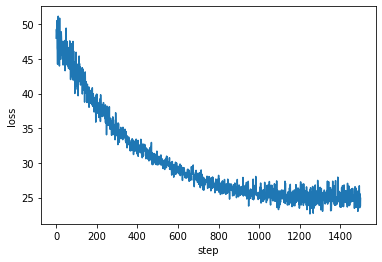

In [296]:
pred = predict(npcs, nharms, wiki_chords[1]['notes'], iterations=1500)

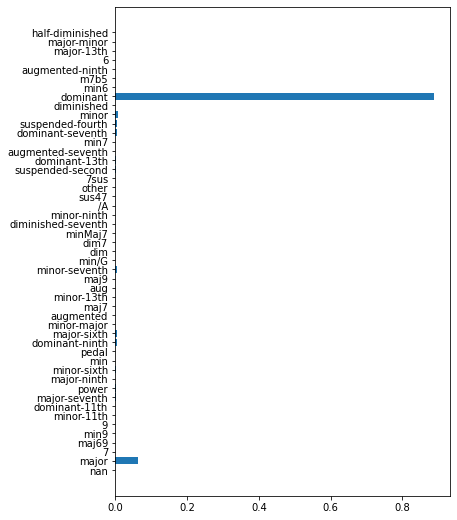

In [297]:
plot_chord_type_dist(pred, wiki_harmtypes)

In [300]:
wiki_chords[1]['label']

41

In [299]:
pred.argmax().item()

41